In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import sys
path = "/content/drive/MyDrive/Colab Notebooks/Project_Dissertation"
sys.path.insert(0,path + "/Code")
import morningStarUtilities

In [14]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,cross_val_score,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [15]:
from sklearn.metrics import confusion_matrix
def plot_conf_matrix(y_test,y_pred,uniqueclassLabel, title="CMatrix"):
  cm = confusion_matrix(y_true=y_test,y_pred=y_pred,labels=uniqueclassLabel)
  plt.figure(figsize=(5,4))
  plt.title(title)
  #ax = plt.subplot()
  sns.heatmap(cm, annot=True,cmap='Blues',
              yticklabels=uniqueclassLabel,xticklabels=uniqueclassLabel,fmt='3g')

### Loading Saved Models

In [16]:
with open('/content/sample_data/model.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential_17", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 16], "dtype": "float32", "sparse": false, "ragged": false, "name": "dense_68_input"}}, {"class_name": "Dense", "config": {"name": "dense_68", "trainable": true, "batch_input_shape": [null, 16], "dtype": "float32", "units": 11, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_69", "trainable": true, "dtype": "float32", "units": 11, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": n

In [17]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('/content/sample_data/model_weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

### Fetch Testing Data

In [18]:
train_df = pd.read_csv(path + "/Data/Final_without_missing_values/morningstar_removedDuplicates_train_withoutLogTransform_withoutM60.csv").set_index("SecId")
test_df = pd.read_csv(path + "/Data/Final_without_missing_values/morningstar_removedDuplicates_test_withoutLogTransform_withoutM60.csv").set_index("SecId")

imp_features = ['SustainabilityRank','GBRReturnM1','GBRReturnM3','GBRReturnM0','GBRReturnM36','OngoingCostActual','TransactionFeeActual','FundTNAV',
'AverageMarketCapital','MorningstarRiskM255','AlphaM36','BetaM36','StandardDeviationM36','SharpeM36','Size','Style']
X_train = train_df[imp_features]
X_test = test_df[imp_features]
y_test = test_df['StarRatingM255']

In [25]:
unique_class_label = list(train_df.StarRatingM255.unique())
unique_class_label.sort()
unique_class_label

[1, 2, 3, 4, 5]

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Performing Predictions

In [20]:
y_pred_loaded = network_loaded.predict(X_test_scaled)
y_pred_loaded = np.argmax(y_pred_loaded, axis=1)
y_pred_loaded +=1

In [23]:
print("Accuracy Score for Neural Network" + "  " 
        + str(accuracy_score(y_test.values,y_pred_loaded)) )
print("F1 Score for Nueral network" + "  " + 
        str(f1_score(y_test.values, y_pred_loaded, average='weighted')))

Accuracy Score for Neural Network  0.5472972972972973
F1 Score for Nueral network  0.5472786395423848


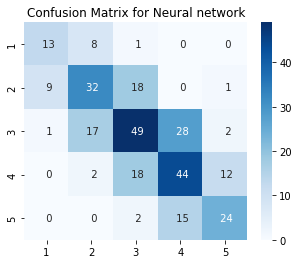

In [28]:
plot_conf_matrix(y_test.values,y_pred_loaded,unique_class_label, title="Confusion Matrix for Neural network")

### Prediction on Asia Developed Dataset

In [33]:
asia_df = pd.read_csv("/content/sample_data/Asia_Developed.csv").set_index("SecId")
asia_df = morningStarUtilities.createSize_InvestmentTypeFeature(asia_df)


In [34]:
asia_df[asia_df.FundTNAV.isnull()]

,Name,StarRatingM255,SustainabilityRank,CategoryName,Yield_M12,GBRReturnW1,GBRReturnM1,GBRReturnM3,GBRReturnM6,GBRReturnM0,GBRReturnM12,GBRReturnM36,GBRReturnM60,MaxFrontEndLoad,OngoingCostActual,TransactionFeeActual,ManagerTenure,FundTNAV,EquityStyleBox,AverageMarketCapital,MorningstarRiskM255,AlphaM36,BetaM36,R2M36,StandardDeviationM36,SharpeM36,ReturnProfilePreservation,ReturnProfileIncome,ReturnProfileHedging,TrackRecordExtension,Size,Style
SecId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F00001071Q,BIEF Emerging Markets A GBP Acc,4,2,Global Emerging Markets Equity,0.62047,1.43,1.64,-3.35,-7.72,0.09,10.79,10.05,NaN,NaN,1.12,1.17,24.08,NaN,2,28614.24791,4,2.47,1.02,89.7,16.24,0.66,3,1,3.0,False,1,2


In [35]:
asia_df.drop(index='F00001071Q',inplace=True)


In [36]:
X_asia = asia_df[imp_features]
y_asia = asia_df['StarRatingM255']
X_asia_scaled = scaler.transform(X_asia)

In [37]:
y_asia_pred = network_loaded.predict(X_asia_scaled)
y_asia_pred = np.argmax(y_asia_pred, axis=1)
y_asia_pred += 1

In [38]:
y_asia.shape

(432,)

In [39]:
y_asia_pred.shape

(432,)

In [41]:
print("Accuracy Score for Neural Network" + "  " 
        + str(accuracy_score(y_asia.values,y_asia_pred)) )
print("F1 Score for Neural Network" + "  " + 
        str(f1_score(y_asia.values, y_asia_pred, average='weighted')))

Accuracy Score for Neural Network  0.5254629629629629
F1 Score for Neural Network  0.4940838050206563


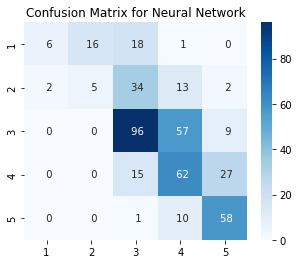

In [42]:
plot_conf_matrix(y_asia.values,y_asia_pred,unique_class_label, title="Confusion Matrix for Neural Network" )